# Schrodinger Equation in 2D

Code adapted from the following sources
- Jonny Hyman's implimentation: https://github.com/jonnyhyman/QuantumWaves
- Original implementation: https://github.com/Azercoco/Python-2D-Simulation-of-Schrodinger-Equation

### Alternating Direction Implicit Method 

*From course notes...*

The ADI method is a powerful implementaion of the operator splitting concept that can be used to solve multi dimensional relaxation iterations. In particular, it can be used for multi dimensional parabolic type equations (it is not necessary in the d=1 implementation of the Crank-Nicholson algorithm that we studied, but it would be useful in diffusion in higher dimensions), or in elliptic problems that require an iterative solution.

The method aims to preserve the algorithm simplicity of explicit methods, while achieving the same stability as implicit methods. We illustrate the method with one example here: the two dimensional diffusion equation,

$$
\frac{\partial u}{\partial t} = D \left( \frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} u}{\partial y^{2}} \right)
$$

The ADI spliting consists of splitting the interval $\Delta t$ in two sub intervals of size $\Delta t/2$, solve the same equation in both, _but use a different algorithm_ in each of the intervals: use an explicit rule along one direction and implicit in the other in one half step, and reverse that in the second half step:

$$
\frac{u_{ij}^{n+1/2} - u_{ij}^{n}}{\Delta t/2} = D \left( \frac{u_{i+1 \ j}^{n+1/2}-2u_{ij}^{n+1/2}+u_{i-1 \ j}^{n+1/2}}{\Delta x^{2}} + \frac{u_{i \ j+1}^{n}-2u_{ij}^{n}+u_{i \ j-1}^{n}}{\Delta ^{2}} \right)
$$
$$
\frac{u_{ij}^{n+1} - u_{ij}^{n+1/2}}{\Delta t/2} = D \left( \frac{u_{i+1 \ j}^{n+1/2}-2u_{ij}^{n+1/2}+u_{i-1 \ j}^{n+1/2}}{\Delta x^{2}} + \frac{u_{i \ j+1}^{n+1}-2u_{ij}^{n+1}+u_{i \ j-1}^{n+1}}{\Delta ^{2}} \right)
$$

with $i = 1, \ldots, N$, $j = 1, \ldots, N$. With this choice of splitting, the first half step is explicit in the $y$ direction but implicit in the $x$ direction, whereas the second half step is explicit in the $x$ direction, but implicit in the $y$ direction. By integrating implicitly only one direction in coordinate space, the iteration is tractable. 

This method is very efficient as the number of calculations required for the solution of a tridiagonal system is linear in $N$. Since one solves $N$ equations, the number of computations will scale with $N^{2}$, which is good for a system in two dimensions.

In [1]:
import os
import sys
import numpy as np
import PIL
from PIL import Image
from time import time
from time import sleep
import scipy.linalg
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
import matplotlib
import animatplot as amp
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from matplotlib import animation
from colorsys import hls_to_rgb
from numba import njit, prange
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D 


c16 = np.complex128
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
# %config InlineBackend.figure_format = 'retina'

# Field

In [2]:
class Field:
    
    def __init__(self):
        self.potential_expr = None
        self.obstacle_expr = None

    def setPotential(self, expr):
        self.potential_expr = expr
        self.test_pot_expr()
        
    def setObstacle(self, expr):
        self.obstacle_expr = expr
        self.test_obs_expr()

    def test_pot_expr(self):
        # required for eval()
        x = 0
        y = 0
        try:
            a = eval(self.potential_expr)
        except:
            print(self.potential_expr)
            print('Potential calculation error: set to 0 by default')
            self.potential_expr = '0'
            
    def test_obs_expr(self):
        # required for eval()
        x = 0
        y = 0
        try:
            a = eval(self.obstacle_expr)
        except:
            print('Error setting obstacle: Set to False by default')
            self.obstacle_expr = 'False'
            
    def isObstacle(self, x, y):
        a = False
        try:
            a = eval(self.obstacle_expr)
        except:
            print(f'Invalid obstacle: {self.obstacle_expr}')
        return a
    
    def getPotential(self, x, y):
        a = 0 + 0j
        try:
            a = eval(self.potential_expr)
        except:
            print(f'Invalid potential: {self.potential_expr}')
        return a
    
    
    
def apply_obstacle(MM, N, meshX, meshY):
    for i in range(N):
        for j in range(N):
            if isObstacle(meshX[i][j], meshY[i][j]):
                MM[i][j] = 0 + 0j
    return MM


def getAdjPos(x, y, N):
    res = []
    res.append((x-1,y))
    res.append((x+1,y))
    res.append((x, y - 1))
    res.append((x,y+1))
    res.append((x - 1,y+1))
    res.append((x - 1,y-1))
    res.append((x + 1,y+1))
    res.append((x+1, y+1))
    return res
    

def colorize(z):
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 * np.pi) + 0.5
    l = 1.0 - 1.0/(1.0 + 2*r**1.2)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    c = c.swapaxes(0,1) 
    return c

# Utils

In [3]:
do_parralel = False


@njit(cache=True, parallel=do_parralel)
def x_concatenate(MM, N):
    result = np.zeros((N*N),dtype=c16)
    for j in prange(N):
        for i in prange(N):
            index = i + N*j
            result[index] = (MM[i][j])
    return result


@njit(cache=True, parallel=do_parralel)
def x_deconcatenate(vector, N):
    result = np.zeros((N, N), dtype=c16)
    for j in prange(N):
        for i in prange(N):
            result[i][j] = vector[N*j + i]
    return result


@njit(cache=True, parallel=do_parralel)
def y_concatenate(MM, N):
    result = np.zeros((N*N),dtype=c16)
    for i in prange(N):
        for j in prange(N):
            index = j + N*i
            result[index] = (MM[i][j])
    return result


@njit(cache=True, parallel=do_parralel)
def y_deconcatenate(vector, N):
    result = np.zeros((N, N), dtype=c16)
    for i in prange(N):
        for j in prange(N):
            result[i][j] = vector[N*i + j]
    return result


@njit(cache=True, parallel=do_parralel)
def dx_square(MM, N, Δx):
    result = np.zeros((N, N), dtype=c16)
    for j in prange(N):
        result[0][j] = MM[1][j] - 2*MM[0][j]
        for i in prange(1, N-1):
            result[i][j] = MM[i+1][j] + MM[i-1][j] - 2*MM[i][j]
        result[N-1][j] = MM[N-2][j] - 2*MM[N-1][j]
    return result / (Δx**2)


@njit(cache=True, parallel=do_parralel)
def dy_square(MM, N, Δx):
    result = np.zeros((N, N), dtype=c16)
    for j in prange(N):
        result[j][0] = MM[j][1] - 2*MM[j][0]
        for i in prange(1, N-1):
            result[j][i] = MM[j][i+1] + MM[j][i-1] - 2*MM[j][i]
        result[j][N-1] = MM[j][N-2] - 2*MM[j][N-1]
    return result / (Δx**2)


@njit(cache=True)  
def integrate(MM, N, Δx):
    S = 0
    air = Δx*Δx/2
    for i in prange(N-1):
        for j in range(N-1):
            AA, AB, BA, BB = MM[i][j], MM[i][j+1], MM[i+1][j], MM[i+1][j+1]
            S += air*(AA+AB+BA)/3
            S += air*(BB+AB+BA)/3
    return S


# Main

In [4]:
N = 256
SIZE = 10
Δt = 0.001
Δx = SIZE/N
V="5*x**2 + 5*y**2"
# V = "False"

x0 =  [-3.0 ]
y0 =  [-1.0 ] 
k_x = [ 9.5 ] 
k_y = [ 2.0 ] 
a_x = [ 0.8 ] 
a_y = [ 0.8 ]


#Potential as a function of x and y
field = Field()
field.setPotential(V) # Ex: x**2+y**2"
potential_boudnary = []


#Obstacle: boolean expression in fct of x and y (set to False if you do not want an obstacle)
obstacles = "(x > 0.5 and x < 1 and not ((y > 0.1 and y < 0.6) or (y < -0.1 and y > -0.6)))"
field.setObstacle(obstacles)    
wall_potential = 1e10

In [5]:
######## Create points at all xy coordinates in meshgrid ######## 
x_axis = np.linspace(-SIZE/2, SIZE/2, N)
y_axis = np.linspace(-SIZE/2, SIZE/2, N)
X, Y = np.meshgrid(x_axis, y_axis)


######## Initialize Wavepackets ######## 
n = 0
phase = np.exp( 1j*(X*k_x[n] + Y*k_y[n]))
px = np.exp( - ((x0[n] - X)**2)/(4*a_x[n]**2))
py = np.exp( - ((y0[n] - Y)**2)/(4*a_y[n]**2))

Ψ = phase*px*py
norm = np.sqrt(integrate(np.abs(Ψ)**2, N, Δx))
Ψ = Ψ/norm

# TODO: figure out best way to add wavefunctions (antisymmetric / symmetric combination?)
for n in range(1,len(x0)):
    phase = np.exp( 1j*(X*k_x[n] + Y*k_y[n]))
    px = np.exp( - ((x0[n] - X)**2)/(4*a_x[n]**2))
    py = np.exp( - ((y0[n] - Y)**2)/(4*a_y[n]**2))

    Ψn = phase*px*py
    norm = np.sqrt(integrate(np.abs(Ψn)**2, N, Δx))

    Ψ += Ψn/norm

NORM = np.sqrt(integrate(np.abs(Ψ)**2, N, Δx))
Ψ = Ψ/NORM

  
######## Create Potential ######## 
V_x = np.zeros(N*N, dtype='c16')
for j in range(N):
    for i in range(N):
        xx = i
        yy = N*j
        if field.isObstacle(x_axis[j], y_axis[i]):
            V_x[xx+yy] = wall_potential
        else:
            V_x[xx+yy] = field.getPotential(x_axis[j], y_axis[i])

V_y = np.zeros(N*N, dtype='c16')
for j in range(N):
    for i in range(N):
        xx = j*N
        yy = i
        if field.isObstacle(x_axis[i], y_axis[j]):
            V_y[xx+yy] = wall_potential
        else:
            V_y[xx+yy] = field.getPotential(x_axis[i], y_axis[j])

V_x_matrix = sp.sparse.diags([V_x], [0])
V_y_matrix = sp.sparse.diags([V_y], [0])


######## Create Hamiltonian ########
LAPLACE_MATRIX = sp.sparse.lil_matrix(-2*sp.sparse.identity(N*N))
for i in range(N):
    for j in range(N-1):
        k = i*N + j
        LAPLACE_MATRIX[k,k+1] = 1
        LAPLACE_MATRIX[k+1,k] = 1

LAPLACE_MATRIX = LAPLACE_MATRIX/(Δx ** 2)

HX = (1*sp.sparse.identity(N*N) - 1j*(Δt/2)*(LAPLACE_MATRIX - V_x_matrix))
HX = csr_matrix(HX)

HY = (1*sp.sparse.identity(N*N) - 1j*(Δt/2)*(LAPLACE_MATRIX - V_y_matrix))
HY = csr_matrix(HY)



######## Place Obstacles ########  
for i in range(0, N):
    for j in range(0, N):
        if field.isObstacle(x_axis[j], y_axis[i]):
            adj = getAdjPos(i, j, N)
            for xx, yy in adj:
                coord_check = xx >= 0 and yy >= 0 and xx < N and yy <N 
                if coord_check and not field.isObstacle(x_axis[yy], y_axis[xx]):
                    potential_boudnary.append((i, j))

In [6]:
def evolve(Ψ):

    vector_wrt_x = x_concatenate(Ψ, N)
    vector_deriv_y_wrt_x = x_concatenate(dy_square(Ψ, N, Δx), N)
    U_wrt_x = vector_wrt_x + (1j*Δt/2)*(vector_deriv_y_wrt_x - V_x*vector_wrt_x)
    U_wrt_x_plus = scipy.sparse.linalg.spsolve(HX, U_wrt_x)
    Ψ = x_deconcatenate(U_wrt_x_plus, N)


    vector_wrt_y = y_concatenate(Ψ, N)
    vector_deriv_x_wrt_y = y_concatenate(dx_square(Ψ, N, Δx), N)
    U_wrt_y = vector_wrt_y  + (1j*Δt/2)*(vector_deriv_x_wrt_y - V_y *vector_wrt_y)
    U_wrt_y_plus = scipy.sparse.linalg.spsolve(HY, U_wrt_y)
    Ψ = y_deconcatenate(U_wrt_y_plus, N)   

    return Ψ

In [7]:
N_iter = 1000
ΨP_arr = np.zeros((N_iter, N, N))
ΨR_arr = np.zeros((N_iter, N, N))

start = time()
for i in range(N_iter):
    Ψ = evolve(Ψ)
    ΨP_arr[i] =  np.abs(Ψ)**2
    ΨR_arr[i] =  Ψ.real
    NORM = np.sqrt(integrate(np.abs(Ψ)**2, N, Δx))
    clear_output(wait=True)
    print("Iteration {} / {}".format(i, N_iter))
    print('Function norm : {0:.9f} '.format(NORM))
    
end = time()
print("{} seconds".format(end-start))

Iteration 999 / 1000
Function norm : 1.000667447 
82.7711329460144 seconds


# Interactive animations (slow frame rate)

### Probability amplitude

In [ ]:
%matplotlib notebook

t = np.linspace(0, 1, N_iter)
XX, YY, TT = np.meshgrid(x_axis, y_axis, t)
ZZ = np.swapaxes(ΨP_arr, 0, 2)

plt.figure(figsize=(9,9))
block = amp.blocks.Pcolormesh(XX[:,:,0], YY[:,:,0], ZZ, t_axis=2, cmap='RdBu', shading='auto')
plt.title(r'$|\Psi(t)|$', fontsize=18)
plt.gca().set_aspect('equal')
plt.axis('off')
timeline = amp.Timeline(t)
anim = amp.Animation([block], timeline)
anim.controls()
plt.show()

In [ ]:
del ZZ, block, anim

### Real part of wave function

In [ ]:
%matplotlib notebook

t = np.linspace(0, 1, N_iter)
XX, YY, TT = np.meshgrid(x_axis, y_axis, t)
ZZ = np.swapaxes(ΨR_arr, 0, 2)

plt.figure(figsize=(9,9))
block = amp.blocks.Pcolormesh(XX[:,:,0], YY[:,:,0], ZZ, t_axis=2, cmap='RdBu', shading='auto')
plt.title(r'$\Psi(t) real$', fontsize=18)
plt.gca().set_aspect('equal')
plt.axis('off')
timeline = amp.Timeline(t)
anim = amp.Animation([block], timeline)
anim.controls()
plt.show()

In [ ]:
del ZZ, block, anim

# Loop of images (faster frame rate)

### Probability amplitude

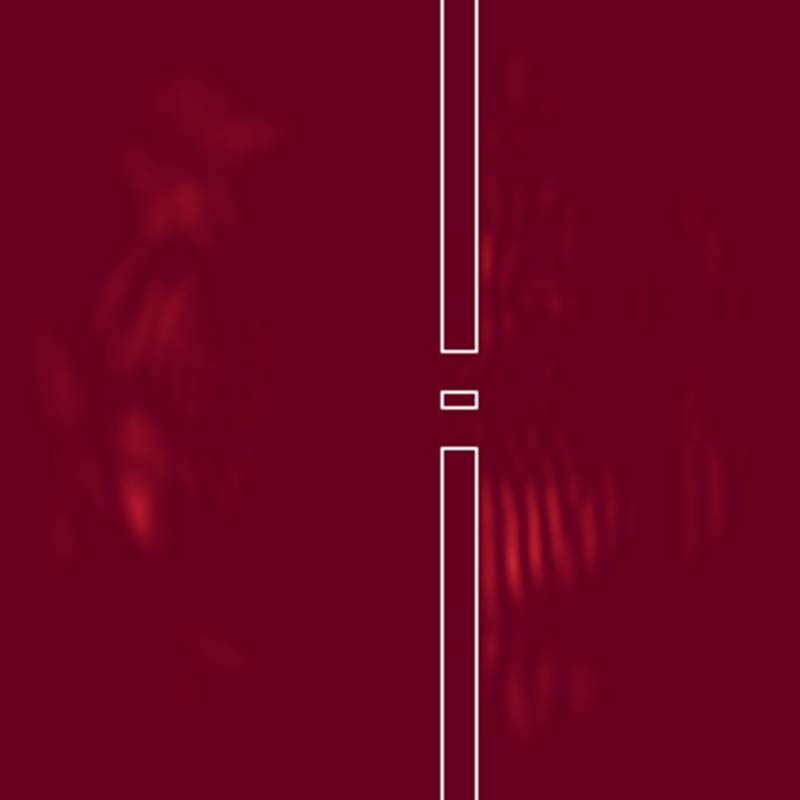

In [9]:
cmap = plt.cm.RdBu
norm = plt.Normalize(ΨP_arr.min(), ΨP_arr.max())

for i in range(N_iter):
    rgb_map = None
    data = ΨP_arr[i]
    rgb_map = cmap(norm(data))
    rgb_map = rgb_map[:, :, :3]
    for i, j in potential_boudnary:
        rgb_map[i][j] = 1, 1, 1
    img = Image.fromarray(np.uint8(rgb_map * 255))
    img = img.resize((800,800))
    clear_output(wait=True)
    display(img)

### Real part of wave function

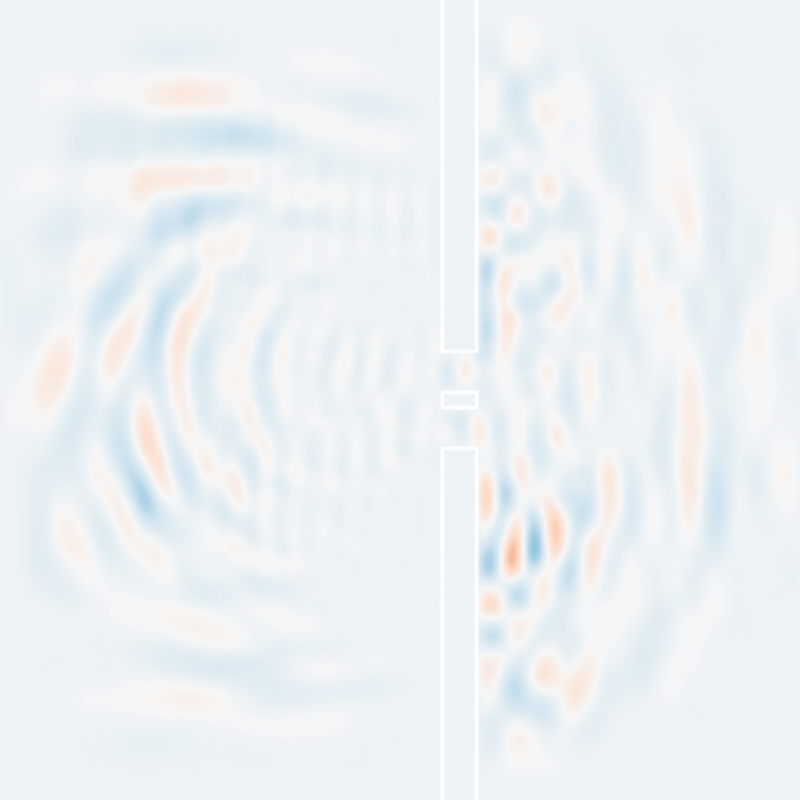

In [10]:
cmap = plt.cm.RdBu
norm = plt.Normalize(ΨR_arr.min(), ΨR_arr.max())

for i in range(N_iter):
    rgb_map = None
    data = ΨR_arr[i]
    rgb_map = cmap(norm(data))
    rgb_map = rgb_map[:, :, :3]
    for i, j in potential_boudnary:
        rgb_map[i][j] = 1, 1, 1
    img = Image.fromarray(np.uint8(rgb_map * 255))
    img = img.resize((800,800))
    clear_output(wait=True)
    display(img)

# 3D Animations

### Loop of 3D surface plots (very slow)

In [ ]:
%matplotlib inline

cmap = plt.cm.viridis
psi = 30

start = time() 
for i in range(N_iter):
    if (i%10 == 0):
        i_start = time()
        psi = psi = psi + 1
        fig = plt.figure(figsize=(16,16))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, ΨP_arr[i,:,:], cmap=cmap, alpha=0.8, rstride=1, cstride=1)
        ax.view_init(20,psi )
        ax.set_zlim([0,1])
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.axis('off')
        clear_output(wait=True)
        display(plt.gcf())
        plt.close()
        i_end = time()
    
end = time()
print("\n{:.4f} seconds".format(end-start))

### Create and save animations

In [ ]:
%matplotlib inline

cmap = plt.cm.viridis
psi = 30

start = time() 
for i in range(N_iter):
    if (i%10 == 0):
        i_start = time()
        psi = psi = psi + 1
        fig = plt.figure(figsize=(16,16))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, ΨR_arr[i,:,:], cmap=cmap, alpha=0.8, rstride=1, cstride=1)
        ax.view_init(20,psi )
        ax.set_zlim([-0.4,1.2])
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.axis('off')
        clear_output(wait=True)
        display(plt.gcf())
        plt.close()
        i_end = time()
    
end = time()
print("\n{:.4f} seconds".format(end-start))

In [ ]:
%matplotlib inline

psi = 30

cmap = plt.cm.viridis

def update_plot(frame_number, zarray, plot):
    global psi
    psi = psi + 0.1
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, zarray[frame_number,:,:], cmap=plt.cm.viridis, rstride=1, cstride=1)
    ax.view_init(20,psi)

    
fig = plt.figure(figsize=(20,20), dpi=200)
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(X, Y, ΨR_arr[0,:,:], cmap=cmap, rstride=1, cstride=1)]
ax.view_init(20,30)
ax.set_zlim([-0.4,1.2])
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.axis('off')

start = time() 

anim = animation.FuncAnimation(fig, update_plot, frames=N_iter, fargs=(ΨR_arr, plot), interval=10)
anim.save('animations/2D_wavepacket_double_slit_v7.mp4', fps=30)
plt.close()

end = time()
print("\n{:.2f} minutes".format((end-start)/60))

In [8]:
# N = 512, Resolution = 2,000 x 2,000 --> 201.41 minutes
# N = 512, Resolution = 3,000 x 3,000 --> 208 minutes